In [ ]:
Ornstein-Uhlenbeck Process

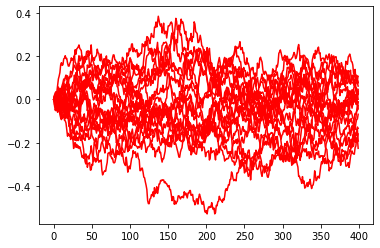

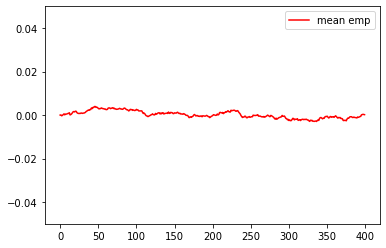

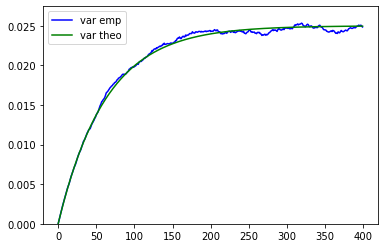

In [8]:
import math
import numpy as np
import matplotlib.pyplot as plt

T = 4.0
nb_simu = 4000
nb_time = 400
delta = 20
nb_t_support = 20
nu = .2
Y0 = .0
dt = T / float(nb_time)
dt_sqrt = math.sqrt(dt)
dW_t = np.random.normal(size=(nb_simu,nb_time)) * dt_sqrt
beta = 0.8

Y = np.zeros((nb_simu, nb_time))
t = np.arange(0, T, dt)

for i in range(0, nb_simu):
    Y[i][0] = Y0
  
for i in range(0, nb_simu):
    for j in range(1, nb_time):
        Y[i][j] = Y[i][j-1] - beta * Y[i][j-1] * dt + nu * dW_t[i, j]
        
for i in range(0, 20):
    plt.plot(Y[i], color='red')
    
plt.show()

mean_emp = np.zeros((nb_time))
var_emp = np.zeros((nb_time))

var_theo = nu * nu / (2.0 * beta) * (1.0 - np.exp(- 2.0 * beta * t))

for i in range(0, nb_time):
    mean_emp[i] = np.mean(Y[:,i])
    var_emp[i] = np.var(Y[:,i])
    
plt.plot(mean_emp, color='red', label='mean emp')
plt.legend()
plt.ylim(-0.05, 0.05)
plt.show()

plt.plot(var_emp, color='blue', label='var emp')
plt.plot(var_theo, color='green', label='var theo')
plt.legend()
plt.ylim(0, 1.1 * max(var_theo))
plt.show()

Determine eigenvalues and eigenvectors

19


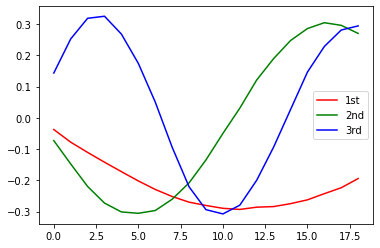

In [32]:
V = np.zeros((nb_simu,nb_t_support-1))
for i_t in range(1, nb_t_support):
    V[:,i_t-1] = Y[:,i_t*delta]

cov = np.cov(V.T)

from numpy import linalg

eigen_values, eigen_vectors = linalg.eig(cov)

eigen = [(eigen_value, eigen_vectors[:,i]) for i, eigen_value in enumerate(eigen_values)]
eigen.sort(key=lambda pair: pair[0], reverse=True)

eigen_values, eigen_vectors = np.array([_eigen[0] for _eigen in eigen]), np.array([_eigen[1] for _eigen in eigen])

A = eigen_vectors

basis_new = [a for a in A]

plt.plot(basis_new[0], color='red', label='1st')
plt.plot(basis_new[1], color='green', label='2nd') 
plt.plot(basis_new[2], color='blue', label='3rd') 
plt.legend()
plt.show()


In [13]:
V_tilde = np.zeros((nb_simu,nb_t_support-1))

for i, v in enumerate(V):
    V_tilde[i] = A.dot(v)

Cross check: Are V_tilde uncorrelated and is there variance given by the eigenvalues?

In [18]:
cov_tilde = np.cov(V_tilde.T)

for i in range(0, nb_t_support-1):
    for j in range(0, nb_t_support-1):
        if i == j:
            #print(cov_tilde[i,j], eigen_values[i])
            assert abs(cov_tilde[i,j] - eigen_values[i]) < 1e-10, 'Deviation too big!'
        elif i < j:
            #print(cov_tilde[i,j])
            assert abs(cov_tilde[i,j]) < 1e-10, 'Deviation too big!'
        else:
            continue
        

Determine how many eigen vectors we need to explain 95% of the stochastic movement

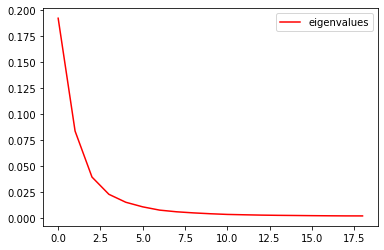

11
17
18


In [49]:
plt.plot(eigen_values, color='red', label='eigenvalues')
plt.legend()
plt.show()

def determine_factors(percentage):
    sum_var = eigen_values.sum()

    s = 0
    for i, eigen_value in enumerate(eigen_values):
        if s < percentage * sum_var:
            s += eigen_value
        else:
            break
            
    return i
 
nb_factors_95 = determine_factors(.95)
print(nb_factors_95)

nb_factors_99 = determine_factors(.99)
print(nb_factors_99)

nb_factors_999 = determine_factors(.999)
print(nb_factors_999)

19


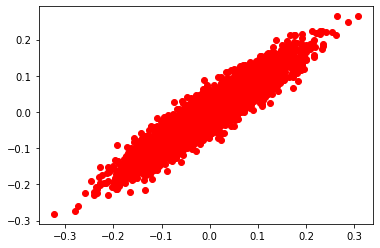

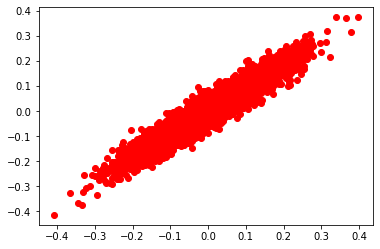

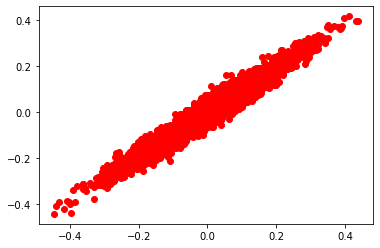

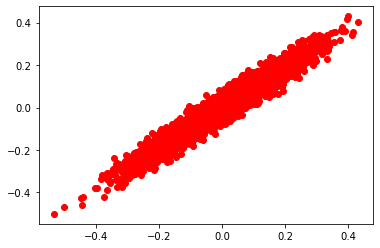

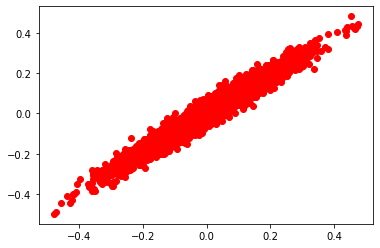

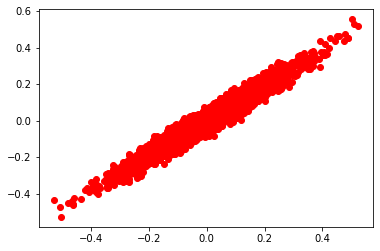

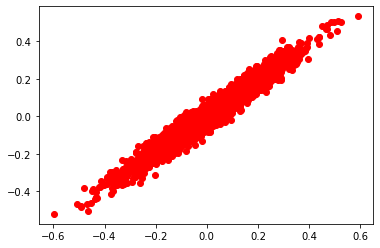

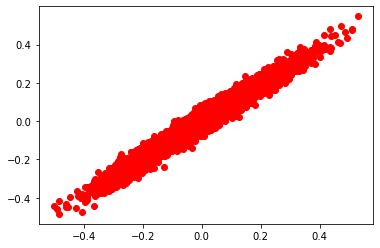

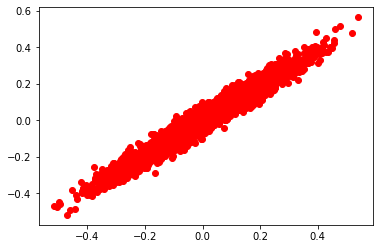

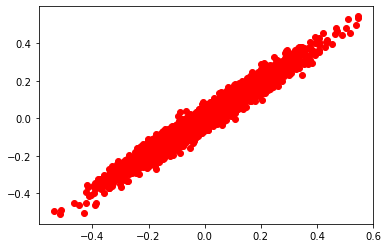

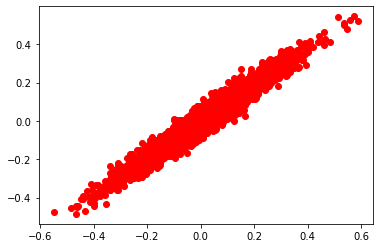

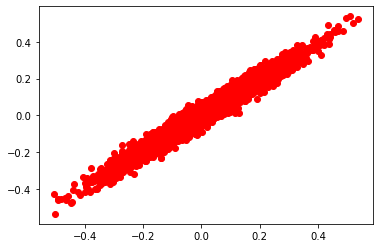

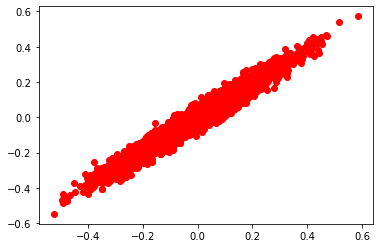

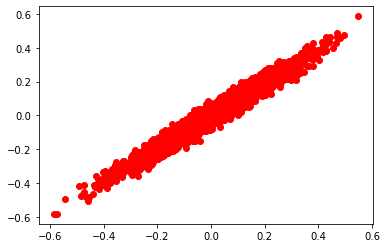

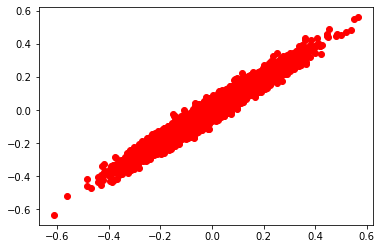

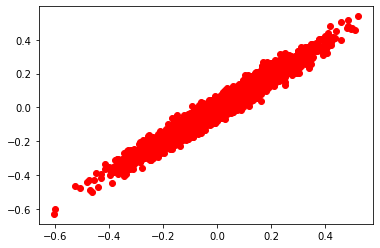

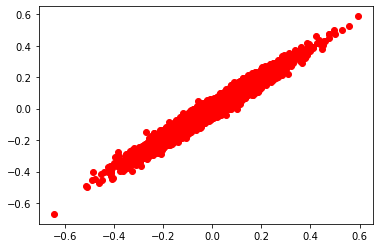

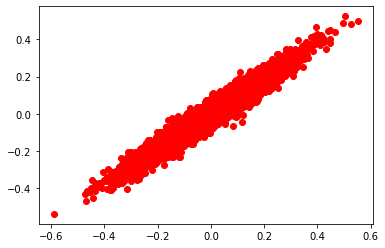

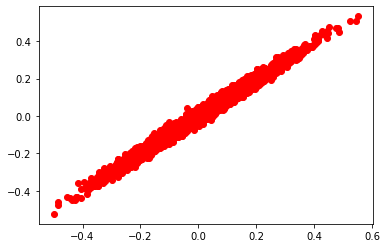

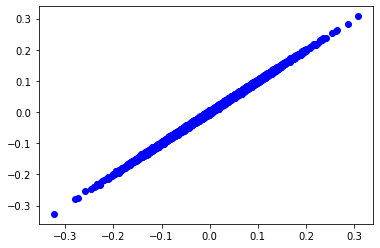

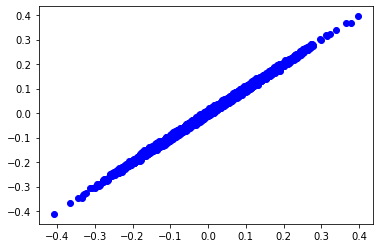

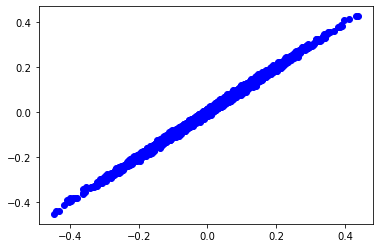

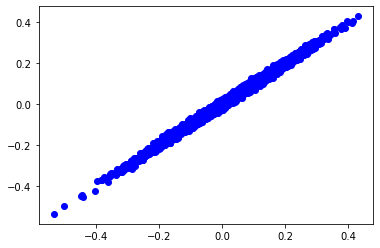

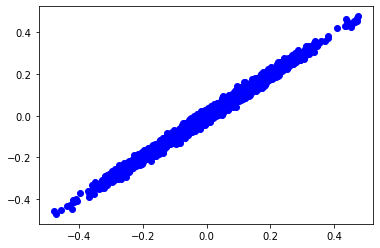

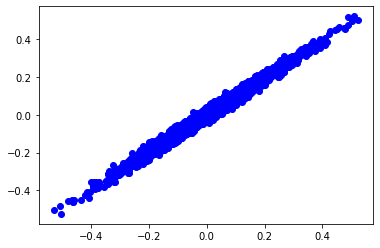

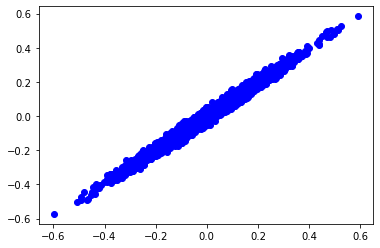

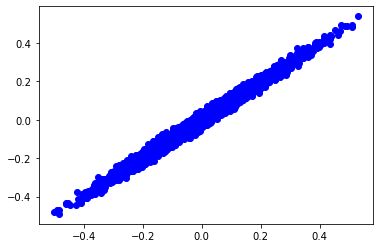

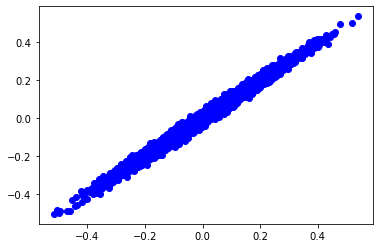

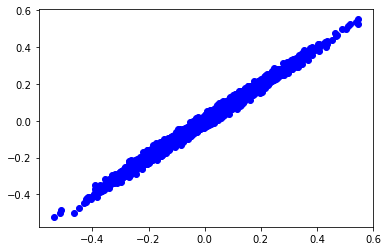

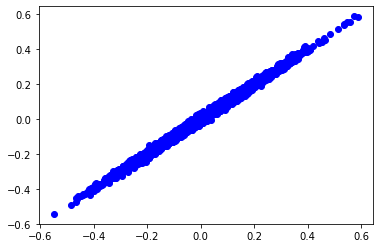

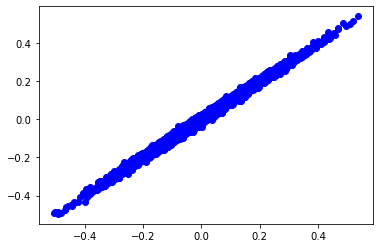

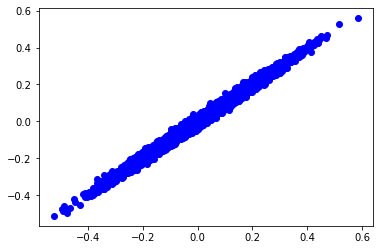

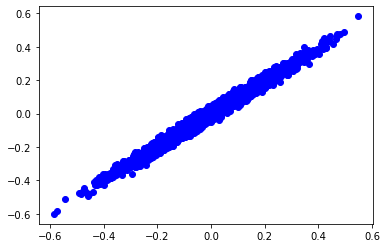

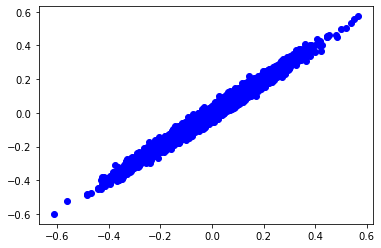

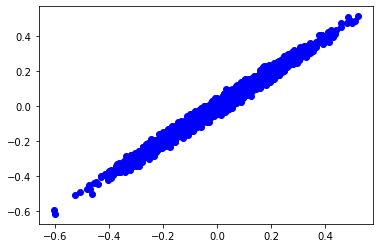

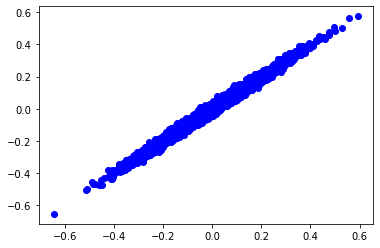

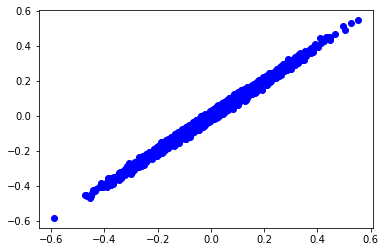

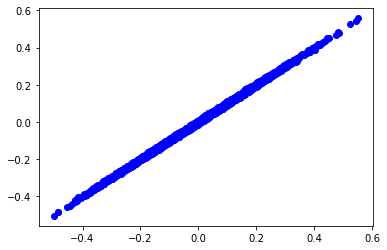

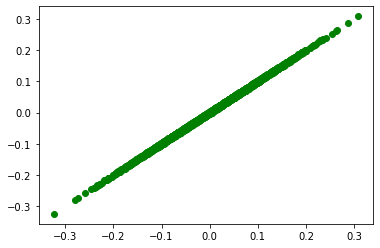

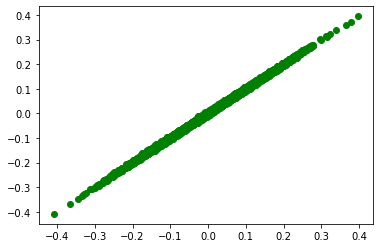

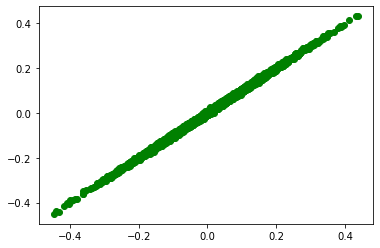

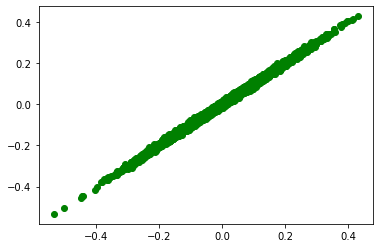

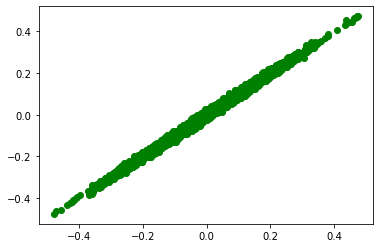

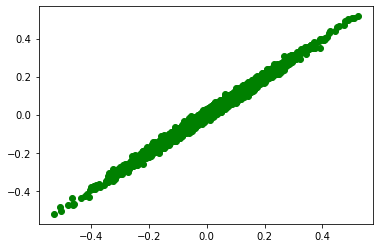

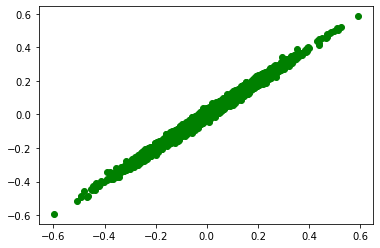

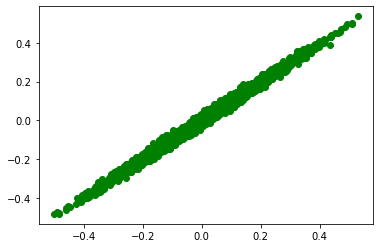

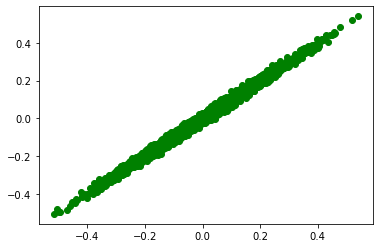

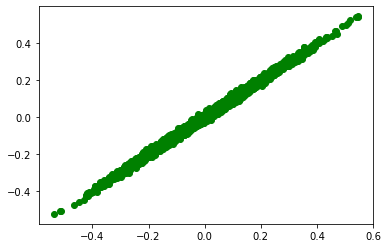

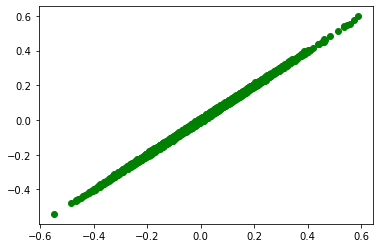

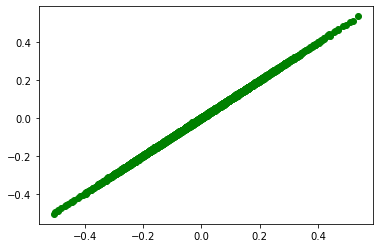

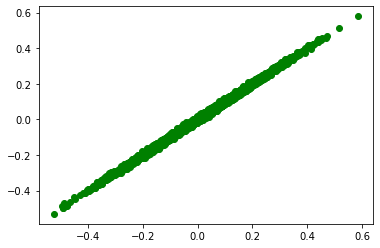

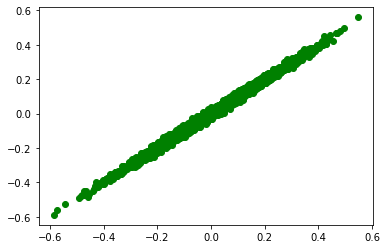

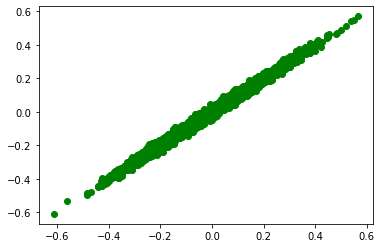

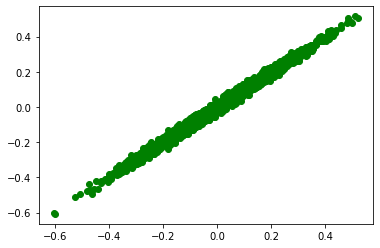

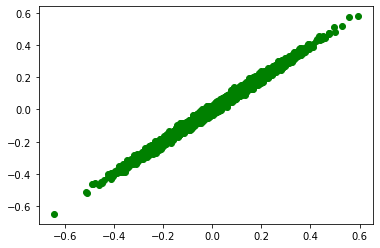

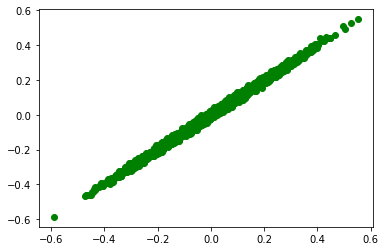

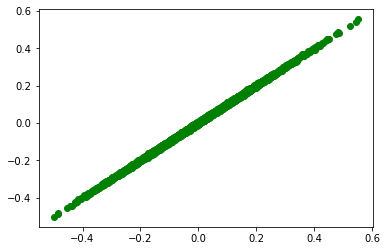

In [50]:
class Proj:
    def __init__(self, A):
        self._A = A

    def __call__(self, v, factors):
        A_reduced = np.zeros((factors,nb_t_support-1))
        
        for i in range(0,factors):
            A_reduced[i] = self._A[i]

        return A_reduced.T.dot(A_reduced).dot(v)

proj = Proj(A)

all_factors = len(V[0])
print(all_factors)

for v in V:
    v_proj = proj(v, all_factors)
    assert linalg.norm(v_proj - v) < 1e-10, 'Deviation too big!'
    
V_95 = np.array([proj(v, nb_factors_95) for v in V])
V_99 = np.array([proj(v, nb_factors_99) for v in V])
V_999 = np.array([proj(v, nb_factors_999) for v in V])

for i_t in range(0, nb_t_support-1):
    plt.scatter(V[:,i_t], V_95[:,i_t], color='red')
    plt.show()
    
for i_t in range(0, nb_t_support-1):
    plt.scatter(V[:,i_t], V_99[:,i_t], color='blue')
    plt.show()
    
for i_t in range(0, nb_t_support-1):
    plt.scatter(V[:,i_t], V_999[:,i_t], color='green')
    plt.show()

Compute first moments

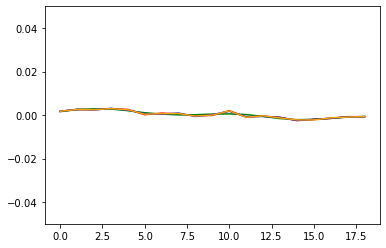

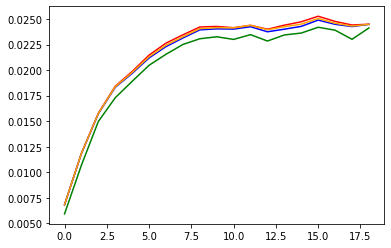

In [52]:
exp_orig = [np.mean(V[:,i_t]) for i_t in range(0, nb_t_support-1)]
exp_95 = [np.mean(V_95[:,i_t]) for i_t in range(0, nb_t_support-1)]
exp_99 = [np.mean(V_99[:,i_t]) for i_t in range(0, nb_t_support-1)]
exp_999 = [np.mean(V_999[:,i_t]) for i_t in range(0, nb_t_support-1)]

var_orig = [np.var(V[:,i_t]) for i_t in range(0, nb_t_support-1)]
var_95 = [np.var(V_95[:,i_t]) for i_t in range(0, nb_t_support-1)]
var_99 = [np.var(V_99[:,i_t]) for i_t in range(0, nb_t_support-1)]
var_999 = [np.var(V_999[:,i_t]) for i_t in range(0, nb_t_support-1)]

plt.plot(exp_orig, color='red', label='original')
plt.plot(exp_95, color='green', label='95%')
plt.plot(exp_99, color='blue', label='99%')
plt.plot(exp_999, color='orange', label='99.9%')
plt.ylim(-0.05, 0.05)
plt.show()

plt.plot(var_orig, color='red', label='original')
plt.plot(var_95, color='green', label='95%')
plt.plot(var_99, color='blue', label='99%')
plt.plot(var_999, color='orange', label='99.9%')
plt.show()

Set up Autoencoder Neural Network

In [61]:
dim_input = nb_t_support - 1
dim_output = dim_input
dim_encoding = 11

from keras.models import Sequential 
from keras.layers import Activation, Dense 
from keras import Input, Model

x_input = Input(shape=(dim_input,))
encoded = Dense(dim_encoding, activation='linear')(x_input)
decoded = Dense(dim_output, activation='linear')(encoded)
autoencoder = Model(x_input, decoded)

autoencoder.compile(optimizer='adam', loss='mse')
print(autoencoder.summary())

history = autoencoder.fit(V.T, V.T,
                epochs=1000,
                batch_size=16,
                shuffle=True,
                validation_split=0.1,
                verbose = 0)

#plot our loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 19)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 11)                220       
_________________________________________________________________
dense_9 (Dense)              (None, 19)                228       
Total params: 448
Trainable params: 448
Non-trainable params: 0
_________________________________________________________________
None


ValueError: in user code:

    C:\Users\bergerd\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    C:\Users\bergerd\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\bergerd\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\bergerd\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\bergerd\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:531 train_step  **
        y_pred = self(x, training=True)
    C:\Users\bergerd\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    C:\Users\bergerd\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\network.py:717 call
        return self._run_internal_graph(
    C:\Users\bergerd\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\network.py:888 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    C:\Users\bergerd\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:885 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\bergerd\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense_8 is incompatible with the layer: expected axis -1 of input shape to have value 19 but received input with shape [None, 4000]
